In [1]:
#@title Initialization
import subprocess
import re

nvcc = subprocess.check_output(["nvcc", "--version"]).decode("utf-8")
version = re.findall("release (\d+\.\d+)", nvcc)[0]

pytorch_suffix = {
    "10.0": "+cu100",
    "10.1": "+cu101",
    "10.2": "",
}

pytorch_version = "1.7.1" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")
torchvision_version = "0.8.2" + (pytorch_suffix[version] if version in pytorch_suffix else "+cu110")

!git clone https://github.com/galatolofederico/clip-glass.git
%cd clip-glass

try:
  import torch
except:
  !pip install torch=={pytorch_version} -f https://download.pytorch.org/whl/torch_stable.html

try:
  import torchvision
except:
  !pip install torchvision=={torchvision_version} -f https://download.pytorch.org/whl/torch_stable.html

!pip install pytorch_pretrained_biggan pymoo kornia ftfy tensorboard

Cloning into 'clip-glass'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 97 (delta 28), reused 83 (delta 17), pack-reused 0
Unpacking objects: 100% (97/97), done.
/content/clip-glass
     |████████████████████████████████| 3.7MB 36.5MB/s 
     |████████████████████████████████| 276kB 47.9MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
     |████████████████████████████████| 133kB 55.1MB/s 
     |████████████████████████████████| 245kB 50.3MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 7.5MB 50.2MB/s 
  Created wheel for pymoo: filename=pymoo-0.4.2.2-cp37-cp37m-linux_x86_64.whl size=4939854 sha256=29996cb738709771b371f01dc795977da34d11096b5272532e5a1be6a0aa3426
  Stored in directory: /root/.cache/pip/wheels/95/13/7a/b9489d4dc66ef0b7d03f6cc3be7535b9b2f18d83893437ad7c
  Created wheel for ftfy: filename=ftfy-6.0.1-cp37-non

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import argparse
import os
import torch
import numpy as np
import pickle
from pymoo.optimize import minimize
from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.factory import get_algorithm, get_decision_making, get_decomposition
from pymoo.visualization.scatter import Scatter
import torchvision
from IPython.display import Image, display
import urllib.request


from config import get_config
from problem import GenerationProblem
from operators import get_operators

In [5]:
%cd /content/clip-glass

target = "airplane" #@param {type:"string"}
config = "DeepMindBigGAN256" #@param ["DeepMindBigGAN256", "DeepMindBigGAN512", "StyleGAN2_ffhq_d", "StyleGAN2_car_d", "StyleGAN2_church_d", "StyleGAN2_ffhq_nod", "StyleGAN2_car_nod", "StyleGAN2_church_nod", "GPT2"]
save_each = 10 #@param {type:"number"}
generations = 100 #@param {type:"number"}

# if config == "GPT2":
#   try:
#     urllib.request.urlretrieve(target, "./target")
#     target = "./target"
#   except Exception as e:
#     print(e)
#     raise Exception("Target must be a vaild URL when using GPT2")
    

# if "ffhq" in config:
#   ! ./download-weights.sh StyleGAN2-ffhq
# if "church" in config:
#   ! ./download-weights.sh StyleGAN2-church
# if "car" in config:
#   ! ./download-weights.sh StyleGAN2-car
# if config == "GPT2":
#   ! ./download-weights.sh GPT2

config = argparse.Namespace(
    config=config,
    target=target,
    device="cuda",
    generations=generations,
    save_each=save_each,
    tmp_folder="./tmp"
)

vars(config).update(get_config(config.config))

/content/clip-glass


In [6]:
def save_callback(algorithm):
    global iteration
    global config

    iteration += 1
    if iteration % config.save_each == 0 or iteration == config.generations:
        if config.problem_args["n_obj"] == 1:
            sortedpop = sorted(algorithm.pop, key=lambda p: p.F)
            X = np.stack([p.X for p in sortedpop])  
        else:
            X = algorithm.pop.get("X")
        
        ls = config.latent(config)
        ls.set_from_population(X)

        with torch.no_grad():
            generated = algorithm.problem.generator.generate(ls, minibatch=config.batch_size)
            name = "genetic-it-%d.jpg" % (iteration) if iteration < config.generations else "genetic-it-final.jpg"

            #if config.task == "txt2img":
              
                #algorithm.problem.generator.save(generated, os.path.join(config.tmp_folder, name))
                #display(Image(os.path.join(config.tmp_folder, name)))

In [10]:
def generate_image(i: int):
  problem = GenerationProblem(config)
  operators = get_operators(config)

  if not os.path.exists(config.tmp_folder): os.mkdir(config.tmp_folder)

  algorithm = get_algorithm(
      config.algorithm,
      pop_size=config.pop_size,
      sampling=operators["sampling"],
      crossover=operators["crossover"],
      mutation=operators["mutation"],
      eliminate_duplicates=True,
      callback=save_callback,
      **(config.algorithm_args[config.algorithm] if "algorithm_args" in config and config.algorithm in config.algorithm_args else dict())
  )

  res = minimize(
      problem,
      algorithm,
      ("n_gen", config.generations),
      save_history=False,
      verbose=False,
  )


  pickle.dump(dict(
      X = res.X,
      F = res.F,
      G = res.G,
      CV = res.CV,
  ), open(os.path.join(config.tmp_folder, "genetic_result"), "wb"))

  # cosine sim
  print(f'Cos-Sim: {-res.F[0]}')

  if config.problem_args["n_obj"] == 1:
      X = np.atleast_2d(res.X)
  else:
      try:
          result = get_decision_making("pseudo-weights", [0, 1]).do(res.F)
      except:
          print("Warning: cant use pseudo-weights")
          result = get_decomposition("asf").do(res.F, [0, 1]).argmin()
      X = res.X[result]
      X = np.atleast_2d(X)

  ls = config.latent(config)
  ls.set_from_population(X)

  with torch.no_grad():
      generated = problem.generator.generate(ls)

  if config.task == "txt2img":
      problem.generator.save(generated, os.path.join(config.tmp_folder, f"{i}_{target}.jpg"))
      display(Image(os.path.join(config.tmp_folder, f"{i}_{target}.jpg")))






GENERATED IMAGES 

TEXT: airplane 

0
Cos-Sim: 0.29931640625


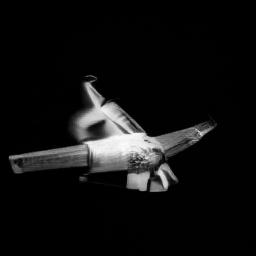



1
Cos-Sim: 0.30419921875


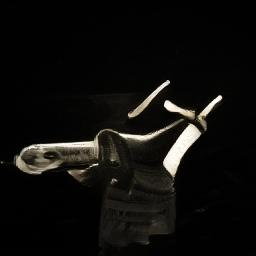



2
Cos-Sim: 0.2978515625


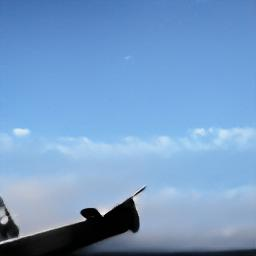

In [11]:
from IPython.display import Image, display
n_img_generated = 3

print('GENERATED IMAGES \n')
print(f'TEXT: {target} \n')
for i in range(n_img_generated):
  print(i)
  iteration=0
  generate_image(i)
  print('\n')

### CLASSIFIER EVALUATION

In [12]:
%cd ..
!git clone https://github.com/vrakesh/CIFAR-10-Classifier
%cd CIFAR-10-Classifier/

/content
Cloning into 'CIFAR-10-Classifier'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10
Unpacking objects: 100% (10/10), done.
/content/CIFAR-10-Classifier


170500096/170498071 [==============================] - 3s 0us/step


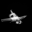

airplane


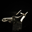

airplane


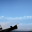

airplane

ACCURACY: 100.0%


In [13]:
from cifar_classifier import cifar_classifier
from PIL import Image
cc = cifar_classifier()
model = cc.get_model('cnn')
model.load_weights('cifar10.model.cnn.hdf5')
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


acc_count = 0
for i in range(n_img_generated):
  im = (Image.open(f'../clip-glass/tmp/{i}_{target}.jpg'))
  im = im.resize((32, 32))
  display(im)
  im = np.expand_dims(im, 0)
  y_hat = model.predict(im)
  predicted_label = cifar10_labels[np.argmax(y_hat[0])]
  print(predicted_label)
  if predicted_label==target:
    acc_count += 1
  
print(f'\nACCURACY: {acc_count/n_img_generated*100}%')

  